# Research

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import pandas as pd
from tensorflow import keras
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import pandas_datareader.data as web
from datetime import datetime
import scipy.stats as scs
import statsmodels.api as sm
import scipy.optimize as sco
import pandas_profiling

Using TensorFlow backend.


In [267]:
sns.set_style('white', {"xtick.major.size": 2, "ytick.major.size": 2})
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71","#f4cae4"]
sns.set_palette(sns.color_palette(flatui,7))
import missingno as msno
p=print

# get index and fed data

f1 = 'USREC' # recession data from FRED

start = pd.to_datetime('1975-01-01')
end = pd.datetime.today()

mkt = '^GSPC'
MKT = (web.DataReader([mkt,'^VIX'], 'yahoo', start, end)['Adj Close']
      .resample('MS') # month start b/c FED data is month start
       .mean()
       .rename(columns={mkt:'SPX','^VIX':'VIX'})
       .assign(SPX_returns=lambda x: np.log(x['SPX']/x['SPX'].shift(1)))
       .assign(VIX_returns=lambda x: np.log(x['VIX']/x['VIX'].shift(1)))
       )

data = (web.DataReader([f1], 'fred', start, end)
        .join(MKT, how='outer')
        .dropna())
# recessions are marked as 1 in the data
recs = data.query('USREC==1')

# Select the three recessions over the time period
recs_pre = recs.loc['1990':'1991']
recs_2k = recs.loc['2001']
recs_2k8 = recs.loc['2008':]

# now we can grab the indices for the start
# and end of each recession
recspre_bgn = recs_pre.index[0]
recspre_end = recs_pre.index[-1]
recs2k_bgn = recs_2k.index[0]
recs2k_end = recs_2k.index[-1]
recs2k8_bgn = recs_2k8.index[0]
recs2k8_end = recs_2k8.index[-1]


In [268]:
def pro_graph(sym, start=None, end=None):
    plot_labels = dict(zip(sym,[[x+'_min_',x+'_max_',x+'_min_idx_',x+'_max_idx_']for x in sym]))
    df_dict ={}
    for x in sym:
        df_dict[x] = web.get_data_yahoo(x,start=datetime(1970, 1, 1))["Adj Close"]
    data = pd.DataFrame(df_dict)
    data = np.log(data / data.shift(1))
    data = data[start:end]
    
    for x in sym:
        plot_labels[x][0] = data[x].min()
        plot_labels[x][1] = data[x].max()
        plot_labels[x][2] = data[x].idxmin(axis=0, skipna=True)
        plot_labels[x][3] = data[x].idxmax(axis=0, skipna=True)
    
    fig, axes = plt.subplots(len(sym),1, figsize=(20,15), sharex=True)
    data[sym].plot(subplots=True, ax=axes, marker='o', ms=2)

    for ax, col in zip(axes, sym):
        ax.axvspan(recspre_bgn, recspre_end, color=sns.xkcd_rgb['grey'], alpha=0.5)
        ax.axvspan(recs2k_bgn, recs2k_end, color=sns.xkcd_rgb['grey'], alpha=0.5)
        ax.axvspan(recs2k8_bgn, recs2k8_end,  color=sns.xkcd_rgb['grey'], alpha=0.5)
        
        ax.axhline(0, color='k', linestyle='-', linewidth=1)
        
        ax.set_title('Monthly ' + col + ' \nRecessions Shaded Gray', fontsize=14)
        
        ax.set_ylabel('Returns')
        ax.set_xlabel('Date')
        
        yticks = ax.get_yticks()
        ax.set_yticklabels(['{:3.1f}%'.format(x*100) for x in yticks]);

        dates_rng = pd.date_range(data.index[0], data.index[-1], freq='1Y')
        plt.xticks(dates_rng, [dtz.strftime('%Y') for dtz in dates_rng], rotation=45)
        
        ax.tick_params(axis='both', which='major', labelsize=11)
        ax.legend(loc='upper left', fontsize=11, frameon=True).get_frame().set_edgecolor('blue')  


    bbox_props = dict(boxstyle="round4, pad=0.6", fc='ivory', ec="black", lw=.5)
    
    for x in sym:
        axes[sym.index(x)].annotate('Global Max = {:.2%}\nDate = {}'
                         .format(plot_labels[x][1], plot_labels[x][3].strftime('%a, %Y-%m-%d')),
                    xy=(plot_labels[x][3], plot_labels[x][1]),  
                    xycoords='data',
                    xytext=(-150, -30),      
                    textcoords='offset points',
                    arrowprops=dict(arrowstyle="->",ec='black'), bbox=bbox_props)    

        axes[sym.index(x)].annotate('Global Min = {:.2%}\nDate = {}'
                         .format(plot_labels[x][0], plot_labels[x][2].strftime('%a, %Y-%m-%d')),
                    xy=(plot_labels[x][2], plot_labels[x][0]),  
                    xycoords='data',
                    xytext=(-150, 30),      
                    textcoords='offset points',
                    arrowprops=dict(arrowstyle="->",ec='black'), bbox=bbox_props) 
    # now to use tight layout
    plt.tight_layout()


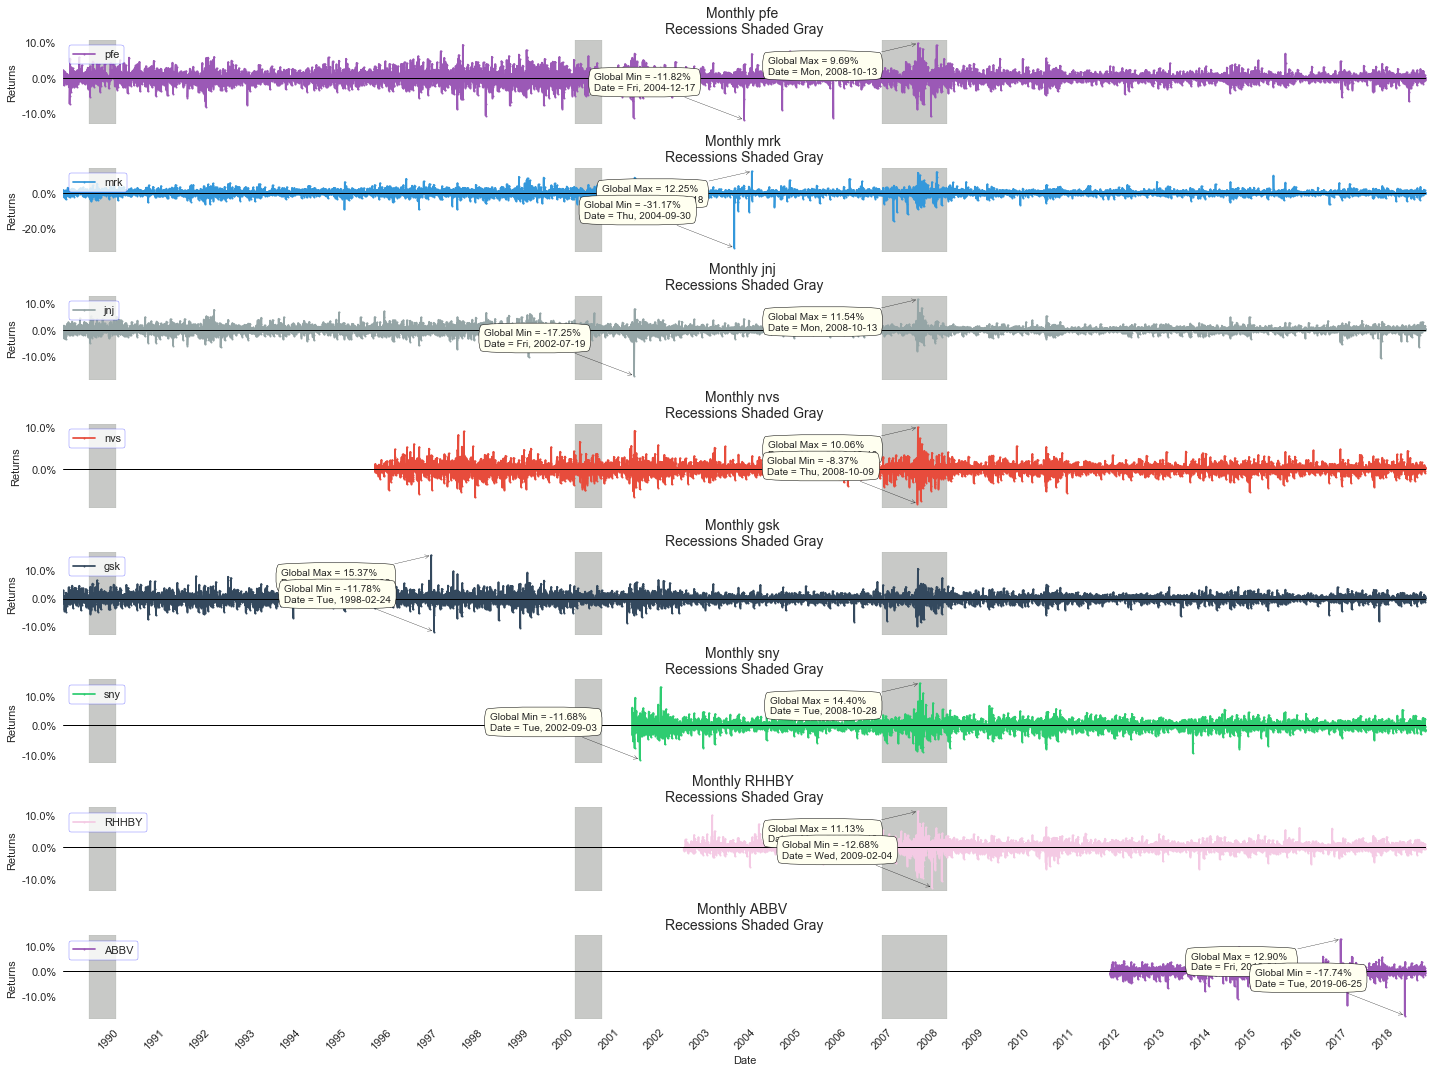

In [269]:
pro_graph(sym,'1990')

In [306]:
sym = ['pfe','mrk','jnj','nvs','gsk','sny','RHHBY','ABBV']
df_dict ={}
for x in sym:
    df_dict[x] = web.get_data_yahoo(x,start=datetime(1970, 1, 1))["Adj Close"]
data = pd.DataFrame(df_dict)

In [271]:
#general market
gm = ['SPY','FEZ','^VIX',]
#Defensive 
defense = ['XLV','XLU','XLP','WMT']
#Cyclicals
cycl =['^DJI','XPH','QQQ','AMZN']

sym2 = gm + defense +cycl
df_dict2 ={}
for x in sym2:
    df_dict2[x] = web.get_data_yahoo(x,start=datetime(1970, 1, 1))["Adj Close"]
metrics = pd.DataFrame(df_dict2)

c:\users\drimbg\.conda\envs\my_env\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


,etf
Date,
1975-01-02,0.000000
1975-01-03,0.000000
1975-01-06,0.000000
1975-01-07,0.000000
1975-01-08,0.000000
1975-01-09,0.000000
1975-01-10,0.000000
1975-01-13,0.000000
1975-01-14,0.000000


In [316]:
def etf_contstructor(sym, start=None, end=None):
    df_dict ={}
    for x in sym:
        df_dict[x] = web.get_data_yahoo(x,start=datetime(1970, 1, 1))["Adj Close"]
    data = pd.DataFrame(df_dict)
    mc = pd.read_excel('marketcap.xlsx',index_col=0)
    wghts = mc.div(mc.sum(axis=1), axis=0)
    start_date = wghts.index.min() - pd.DateOffset(day=1)
    end_date = wghts.index.max() + pd.DateOffset(day=31)
    dates = pd.date_range(start_date, end_date, freq='D')
    dates.name = 'date'
    data = data[start:end]
    wghts = wghts.reindex(dates, method='ffill')
    wghts = wghts[data.columns]
    wghts = wghts.loc[data.index]
    etf = pd.DataFrame(wghts.values*data.values, columns=wghts.columns, index=wghts.index).sum(axis=1)
    etf= pd.DataFrame(etf,columns=['etf'])
    return etf

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1997 entries, 2012-01-03 to 2019-12-09
Data columns (total 8 columns):
pfe      1997 non-null float64
mrk      1997 non-null float64
jnj      1997 non-null float64
nvs      1997 non-null float64
gsk      1997 non-null float64
sny      1997 non-null float64
RHHBY    1997 non-null float64
ABBV     1747 non-null float64
dtypes: float64(8)
memory usage: 140.4 KB


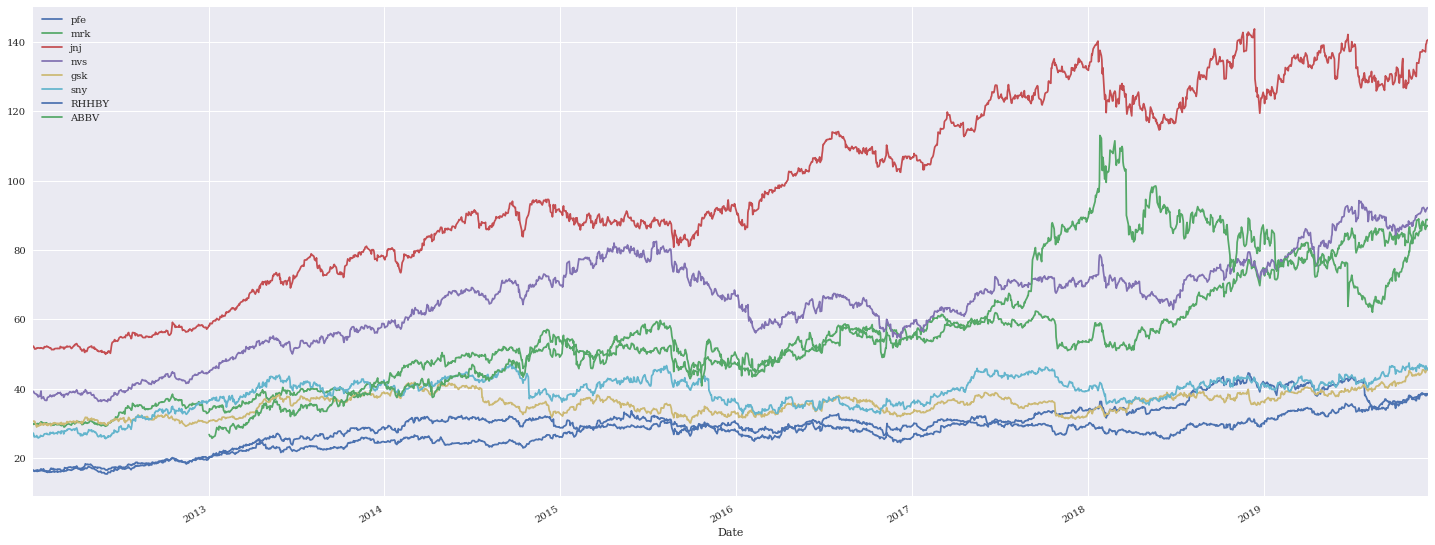

In [303]:
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
data.info()
data.plot(figsize=(25, 10))

In [304]:
np.log(etf / etf.shift(1)).kurt()

etf    4.125878
dtype: float64

In [297]:
#tmp = data.merge(ETF, how='outer', left_index=True, right_index=True)
#tmp.to_excel('tmp.xlsx')

In [336]:
def statsummary(sym, etf_ticks=sym,year="2004"):
    etf= etf_contstructor(etf_ticks,year)
    df_dict ={}
    for x in sym:
        df_dict[x] = web.get_data_yahoo(x,start=datetime(1970, 1, 1))["Adj Close"]
    data = pd.DataFrame(df_dict)
    data = data.merge(etf, how='outer', left_index=True, right_index=True)
    data = np.log(data / data.shift(1))
    mean = data.mean()
    std =data.std()
    skew = data.skew()
    kurt = data.kurt()
    stats = pd.concat([mean, std, skew, kurt], axis=1)
    stats.columns = ['Mean',"Standard Deviation","Skew","Kurtosis"]
    stats.plot(kind='bar',figsize=(20,6),subplots=True)
    plt.show()
    display(stats)

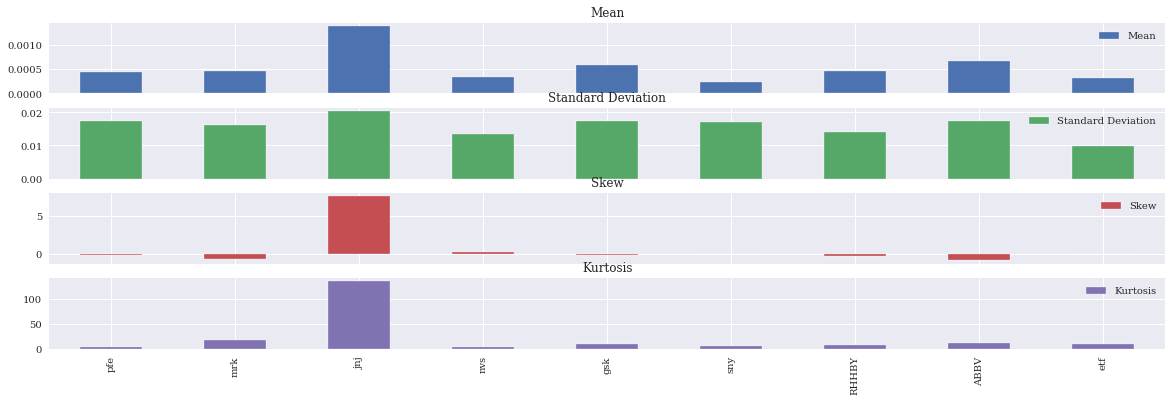

,Mean,Standard Deviation,Skew,Kurtosis
pfe,0.000438,0.017302,-0.167290,4.278123
mrk,0.000463,0.016096,-0.726179,16.593149
jnj,0.001385,0.020411,7.593834,135.370806
nvs,0.000332,0.013476,0.157615,4.034261
gsk,0.000589,0.017231,-0.161181,9.626655
sny,0.000233,0.016995,-0.001792,5.772816
RHHBY,0.000464,0.014152,-0.330252,7.767559
ABBV,0.000674,0.017424,-0.893805,12.164209
etf,0.000319,0.009748,-0.062983,10.177464


In [337]:
statsummary(sym)

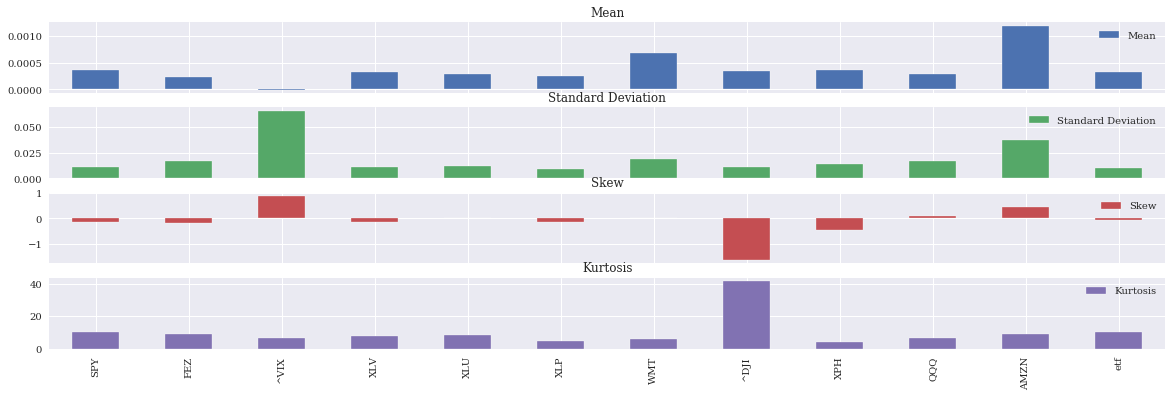

,Mean,Standard Deviation,Skew,Kurtosis
SPY,0.000365,0.011432,-0.144632,10.365866
FEZ,0.000234,0.016410,-0.177306,9.115200
^VIX,-0.000016,0.065541,0.889617,6.451234
XLV,0.000317,0.011226,-0.152798,8.037114
XLU,0.000281,0.011571,0.025129,8.640061
XLP,0.000252,0.009369,-0.158765,4.409831
WMT,0.000676,0.018773,0.002624,5.878832
^DJI,0.000350,0.010954,-1.658800,41.675716
XPH,0.000363,0.013628,-0.458107,4.120454
QQQ,0.000291,0.017328,0.093145,6.408493


In [338]:
statsummary(sym2,sym)

In [342]:
#rets = np.log(data / data.shift(1))
#rets.cumsum().apply(np.exp).plot(figsize=(10, 6))
#rets.cumsum().apply(np.exp). resample('1m', label='right').last().plot(figsize=(10, 6));

In [343]:
data2 = data.dropna()
rollingstats = pd.DataFrame()
window = 20
for x in sym:
    rollingstats[x+' '+'min'] = data2[x].rolling(window=window).min()
    rollingstats[x+' '+'mean'] = data2[x].rolling(window=window).mean()
    rollingstats[x+' '+'std'] = data2[x].rolling(window=window).std()
    rollingstats[x+' '+'median'] = data2[x].rolling(window=window).median()
    rollingstats[x+' '+'max'] = data2[x].rolling(window=window).max()
    rollingstats[x+' '+'ewm'] = data2[x].ewm(halflife=0.5, min_periods=window).mean()
rollingstats

,pfe min,pfe mean,pfe std,pfe median,pfe max,pfe ewm,mrk min,mrk mean,mrk std,mrk median,...,RHHBY std,RHHBY median,RHHBY max,RHHBY ewm,ABBV min,ABBV mean,ABBV std,ABBV median,ABBV max,ABBV ewm
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


[None, None, None, None, None, None, None, None]

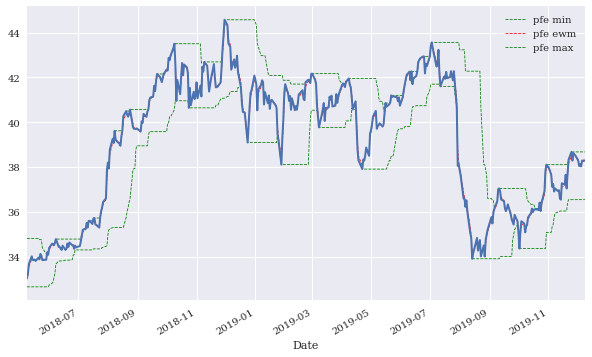

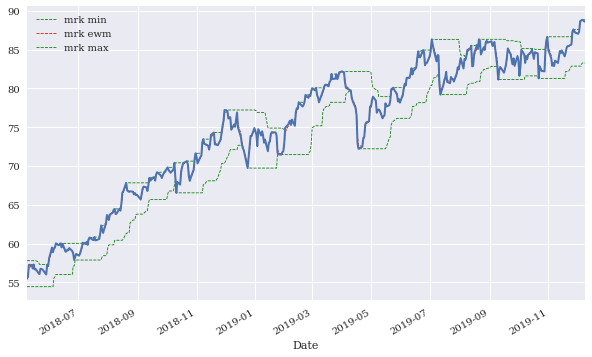

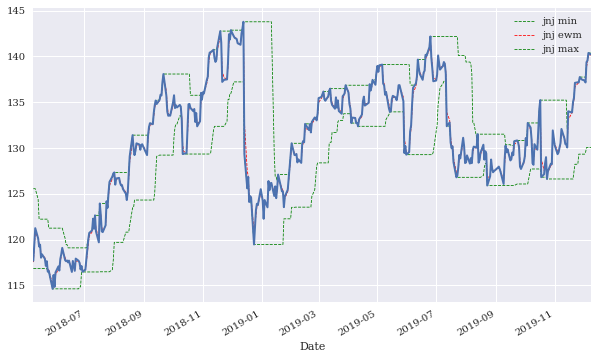

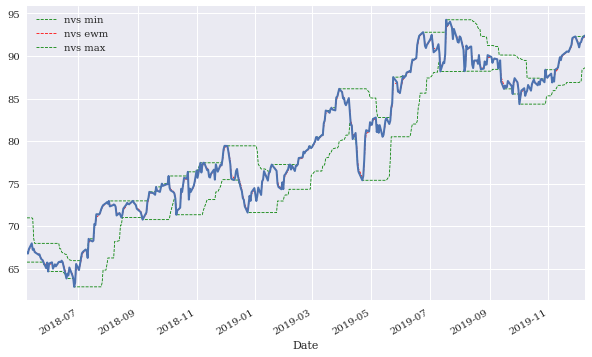

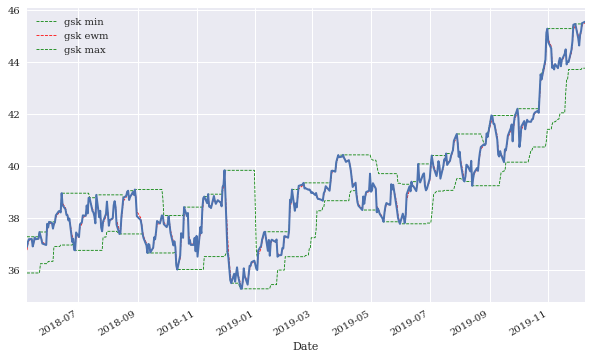

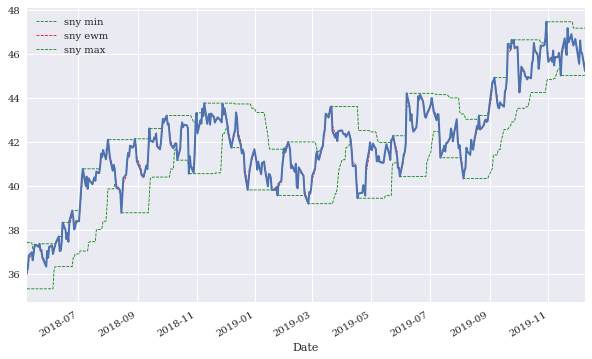

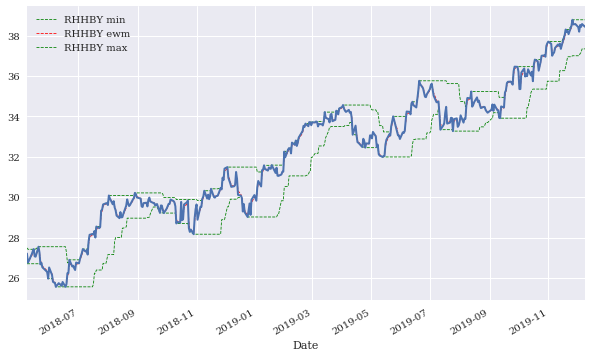

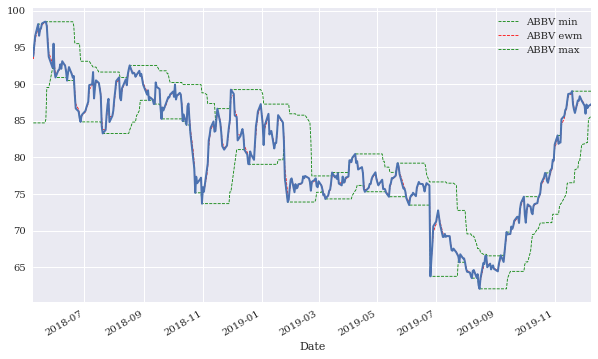

In [344]:
def roller(tick):
    ax = rollingstats[[tick+' min', tick+' ewm', tick+' max']].iloc[-400:].plot(figsize=(10, 6), style=['g--', 'r--', 'g--'], lw=0.8)
    data[tick].iloc[-400:].plot(ax=ax, lw=2.0);
list(map(roller, sym))

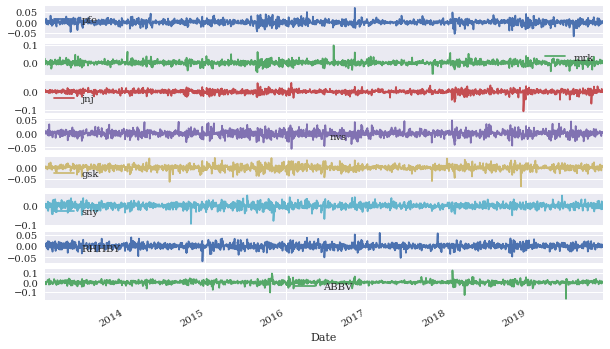

In [345]:
rets = np.log(data / data.shift(1))
rets.dropna(inplace=True)
rets.plot(subplots=True, figsize=(10, 6));

In [346]:
def corr(tick):
    tmp= ['spy']
    tmp.append(tick)
    df_dict ={}
    for x in tmp:
        df_dict[x] = web.get_data_yahoo(x,start=datetime(1970, 1, 1))["Adj Close"]
    data = pd.DataFrame(df_dict)
    rets = np.log(data / data.shift(1))
    rets.dropna(inplace=True)
    return rets

def corrg(tick):
    pd.plotting.scatter_matrix(corr(tick),alpha=0.2,diagonal='hist', figsize=(10, 6));

def corrgraph(tick):
    rets= corr(tick)
    ax = rets['spy'].rolling(window=252).corr(rets[tick]).plot(figsize=(10, 6))
    ax.axhline(rets.corr().iloc[0, 1], c='r')

corr_all = list(map(corr,sym))

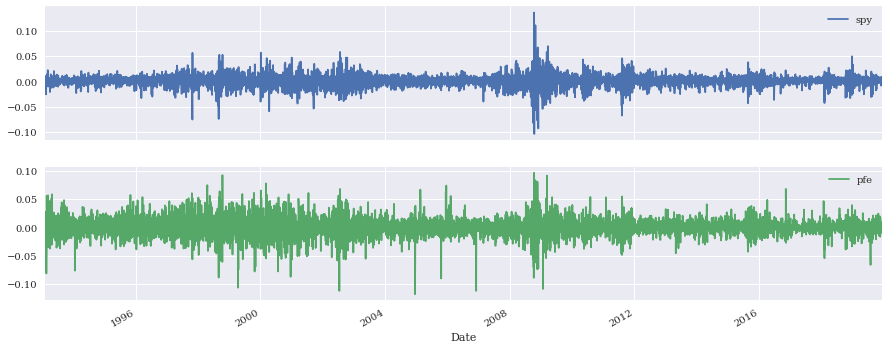

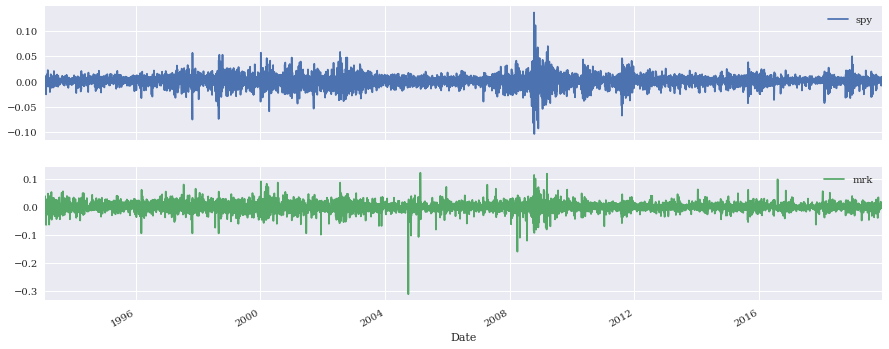

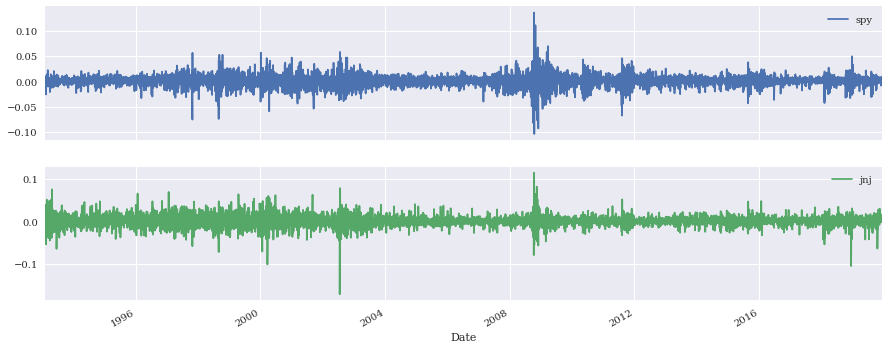

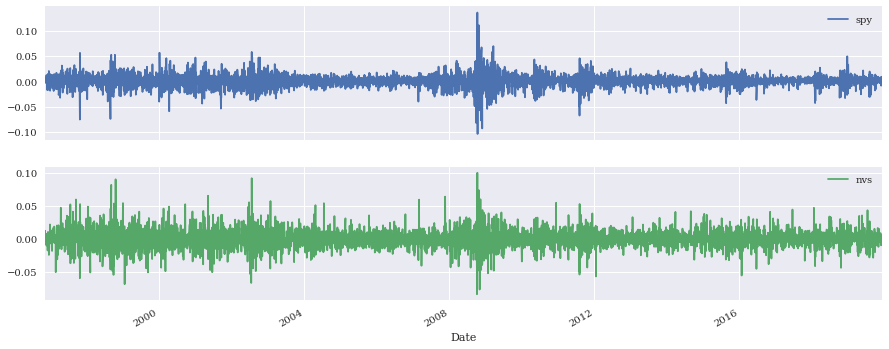

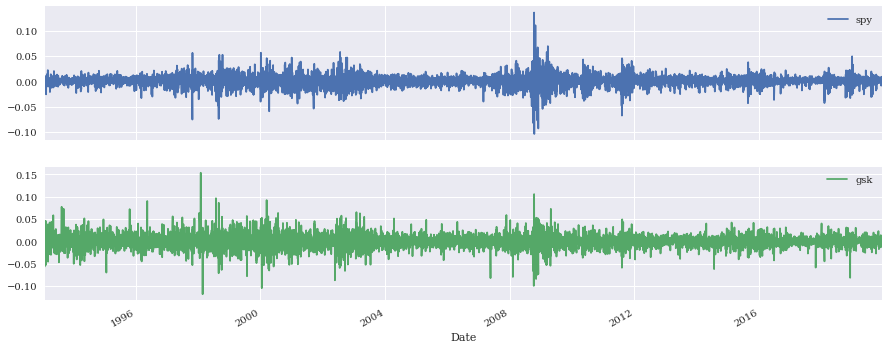

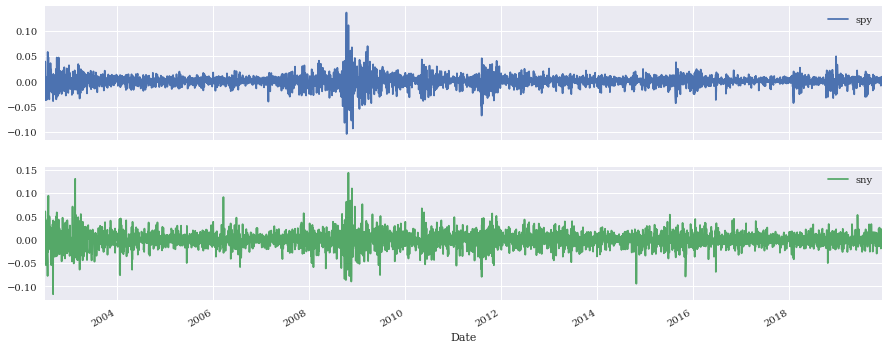

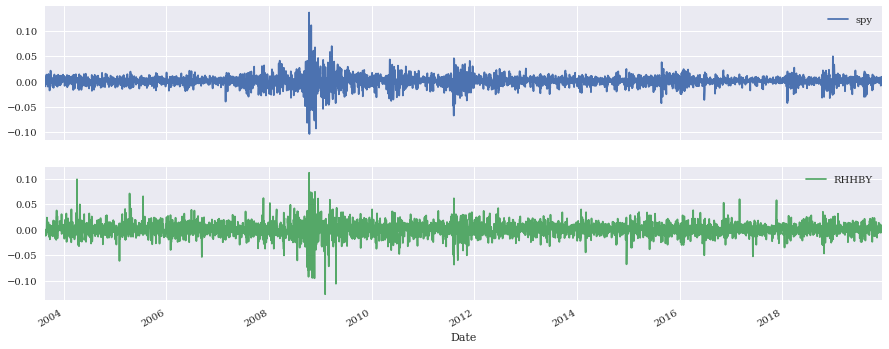

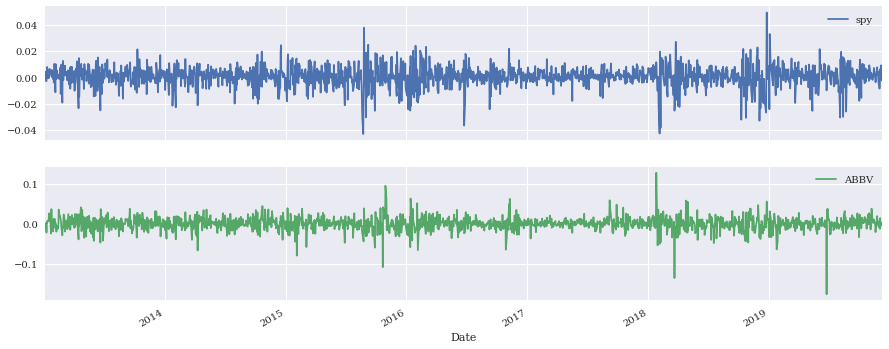

In [347]:
for i in range(len(sym)):
    corr_all[i].plot(subplots=True, figsize=(15, 6));

In [ ]:
#ols
#reg = np.polyfit(rets['spy'], rets['pfe'], deg=1)
#ax = rets.plot(kind='scatter', x='spy', y='pfe', figsize=(10, 6))
#ax.plot(rets['spy'], np.polyval(reg, rets['spy']), 'r', lw=2);

In [ ]:
#time for statistics
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1743 entries, 2013-01-02 to 2019-12-03
Data columns (total 7 columns):
pfe      1743 non-null float64
mrk      1743 non-null float64
nvs      1743 non-null float64
gsk      1743 non-null float64
sny      1743 non-null float64
RHHBY    1743 non-null float64
ABBV     1743 non-null float64
dtypes: float64(7)
memory usage: 108.9 KB


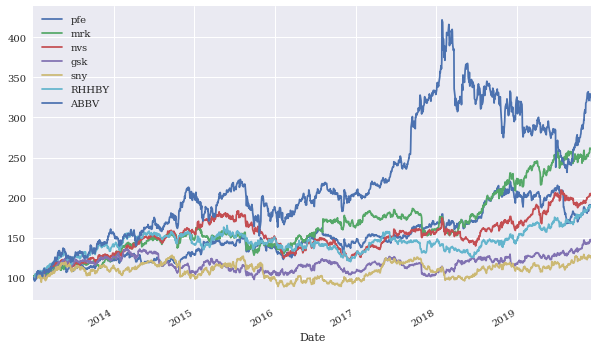

In [ ]:
(data / data.iloc[0] * 100).plot(figsize=(10, 6))

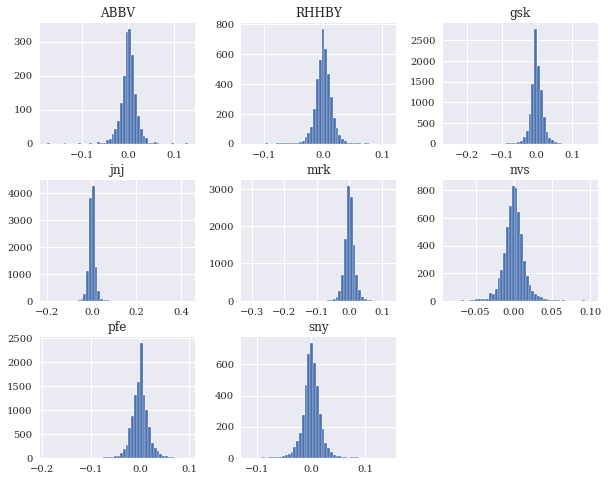

In [348]:
log_returns = np.log(data / data.shift(1))
log_returns.head()
log_returns.hist(bins=50, figsize=(10, 8));

In [349]:
def print_statistics(array):
    sta = scs.describe(array)
    print('%14s %15s' % ('statistic', 'value'))
    print(30 * '-')
    print('%14s %15.5f' % ('size', sta[0]))
    print('%14s %15.5f' % ('min', sta[1][0]))
    print('%14s %15.5f' % ('max', sta[1][1]))
    print('%14s %15.5f' % ('mean', sta[2]))
    print('%14s %15.5f' % ('std', np.sqrt(sta[3])))
    print('%14s %15.5f' % ('skew', sta[4]))
    print('%14s %15.5f' % ('kurtosis', sta[5]))

    
def normality_tests(arr):
    print('Skew of data set  %14.3f' % scs.skew(arr))
    print('Skew test p-value %14.3f' % scs.skewtest(arr)[1])
    print('Kurt of data set  %14.3f' % scs.kurtosis(arr))
    print('Kurt test p-value %14.3f' % scs.kurtosistest(arr)[1])
    print('Norm test p-value %14.3f' % scs.normaltest(arr)[1])


In [351]:
for s in sym:
    print('\nResults for symbol {}'.format(s))
    print(32 * '-')
    log_data = np.array(log_returns[s].dropna())
    normality_tests(log_data)


Results for symbol pfe
--------------------------------
Skew of data set          -0.189
Skew test p-value          0.000
Kurt of data set           4.501
Kurt test p-value          0.000
Norm test p-value          0.000

Results for symbol mrk
--------------------------------
Skew of data set          -0.783
Skew test p-value          0.000
Kurt of data set          17.970
Kurt test p-value          0.000
Norm test p-value          0.000

Results for symbol jnj
--------------------------------
Skew of data set           8.130
Skew test p-value          0.000
Kurt of data set         143.649
Kurt test p-value          0.000
Norm test p-value          0.000

Results for symbol nvs
--------------------------------
Skew of data set           0.158
Skew test p-value          0.000
Kurt of data set           4.030
Kurt test p-value          0.000
Norm test p-value          0.000

Results for symbol gsk
--------------------------------
Skew of data set          -0.161
Skew test p-value     

In [359]:
def stats(sym):
    df_dict ={}
    for x in sym:
        df_dict[x] = web.get_data_yahoo(x,start=datetime(1970, 1, 1))["Adj Close"]
    data = pd.DataFrame(df_dict)
    rets = np.log(data / data.shift(1))
    display(rets.corr())

In [361]:
stats(sym+sym2)

,pfe,mrk,jnj,nvs,gsk,sny,RHHBY,ABBV,SPY,FEZ,^VIX,XLV,XLU,XLP,WMT,^DJI,XPH,QQQ,AMZN
pfe,1.000000,0.513620,0.323130,0.391154,0.383809,0.474181,0.381111,0.445273,0.541666,0.528144,-0.385351,0.592645,0.369524,0.606140,0.289473,0.554372,0.618362,0.353218,0.209003
mrk,0.513620,1.000000,0.337012,0.356398,0.383725,0.415622,0.324754,0.380739,0.500966,0.463397,-0.368342,0.544265,0.381897,0.545659,0.282759,0.551444,0.565008,0.309890,0.165561
jnj,0.323130,0.337012,1.000000,0.351704,0.307796,0.435474,0.360661,0.395127,0.505119,0.522231,-0.377305,0.558127,0.406931,0.608363,0.210431,0.551678,0.551081,0.309672,0.155701
nvs,0.391154,0.356398,0.351704,1.000000,0.481715,0.560190,0.597198,0.347431,0.467885,0.572519,-0.372339,0.472682,0.333803,0.423890,0.254466,0.468228,0.507713,0.334438,0.185116
gsk,0.383809,0.383725,0.307796,0.481715,1.000000,0.566241,0.471107,0.328371,0.480625,0.555322,-0.355943,0.484527,0.374665,0.499900,0.278794,0.502902,0.498569,0.356872,0.195349
sny,0.474181,0.415622,0.435474,0.560190,0.566241,1.000000,0.529611,0.284632,0.602420,0.694311,-0.460817,0.570179,0.412928,0.506238,0.325907,0.598624,0.510999,0.532086,0.323039
RHHBY,0.381111,0.324754,0.360661,0.597198,0.471107,0.529611,1.000000,0.241095,0.462199,0.533515,-0.353959,0.443109,0.326746,0.388839,0.233724,0.455406,0.411782,0.399688,0.240720
ABBV,0.445273,0.380739,0.395127,0.347431,0.328371,0.284632,0.241095,1.000000,0.503377,0.367326,-0.413978,0.630430,0.194120,0.343405,0.200100,0.464572,0.503690,0.459818,0.268562
SPY,0.541666,0.500966,0.505119,0.467885,0.480625,0.602420,0.462199,0.503377,1.000000,0.842680,-0.718919,0.781525,0.601315,0.673344,0.504594,0.946121,0.699615,0.830140,0.439876
FEZ,0.528144,0.463397,0.522231,0.572519,0.555322,0.694311,0.533515,0.367326,0.842680,1.000000,-0.635751,0.676270,0.564197,0.646603,0.410989,0.827514,0.586012,0.747725,0.439107


In [362]:
from math import sqrt
weights = np.random.random(noa)  
weights /= np.sum(weights)
weights = np.random.random(noa)  

#E[X]--np.sum(rets.mean() * weights) * 252
#var--np.dot(weights.T, np.dot(rets.cov() * 252, weights))
#vol--sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))
def port_ret(weights):
             return np.sum(rets.mean() * weights) * 252
def port_vol(weights):
             return np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

In [363]:
prets = []
pvols = []
for p in range (5000):  
    weights = np.random.random(noa)  
    weights /= np.sum(weights)  
    prets.append(port_ret(weights))  
    pvols.append(port_vol(weights))  
prets = np.array(prets)
pvols = np.array(pvols)

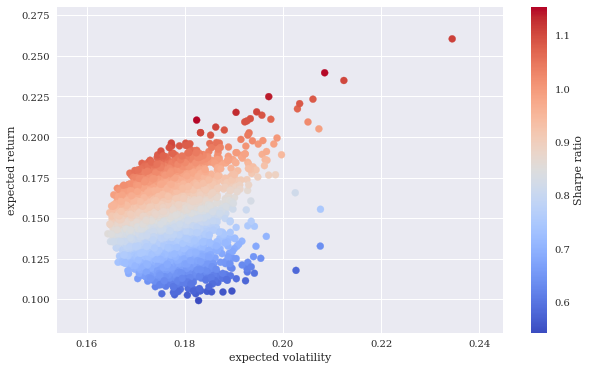

In [364]:
plt.figure(figsize=(10, 6))
plt.scatter(pvols, prets, c=prets / pvols, marker='o', cmap='coolwarm')
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio');

In [365]:
def min_func_sharpe(weights):
    return -port_ret(weights) / port_vol(weights)

cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
bnds = tuple((0, 1) for x in range(noa))
eweights = np.array(noa * [1. / noa,])
min_func_sharpe(eweights)
opts = sco.minimize(min_func_sharpe, eweights, method='SLSQP', bounds=bnds, constraints=cons)
optv = sco.minimize(port_vol, eweights,method='SLSQP', bounds=bnds,constraints=cons)

In [366]:
cons = ({'type': 'eq', 'fun': lambda x:  port_ret(x) - tret}, {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
bnds = tuple((0, 1) for x in weights)
trets = np.linspace(0.05, 0.2, 50)
tvols = []

for tret in trets:
    res = sco.minimize(port_vol, eweights, method='SLSQP', bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)

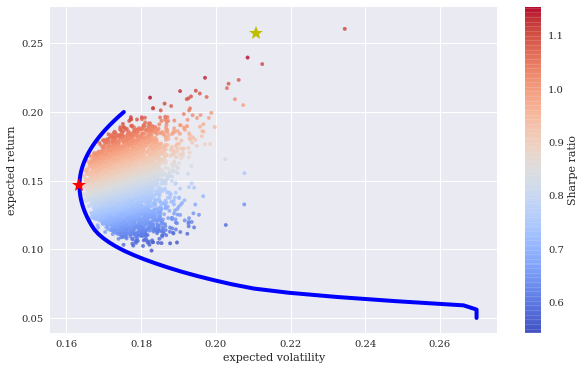

In [367]:
plt.figure(figsize=(10, 6))
plt.scatter(pvols, prets, c=prets / pvols, marker='.', alpha=0.8, cmap='coolwarm')
plt.plot(tvols, trets, 'b', lw=4.0)
plt.plot(port_vol(opts['x']), port_ret(opts['x']), 'y*', markersize=15.0)
plt.plot(port_vol(optv['x']), port_ret(optv['x']), 'r*', markersize=15.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')


In [378]:
def bayes(tick):
    tmp= ['spy']
    tmp.append(tick)
    df_dict ={}
    for x in tmp:
        df_dict[x] = web.get_data_yahoo(x,start=datetime(1970, 1, 1))["Adj Close"]
    data = pd.DataFrame(df_dict)
    data=data.dropna()
    data = data / data.iloc[0] #normalize to 1
    return data
data = bayes('pfe')
data.iloc[-1] / data.iloc[0] - 1
data.corr()

,spy,pfe
spy,1.000000,0.917768
pfe,0.917768,1.000000


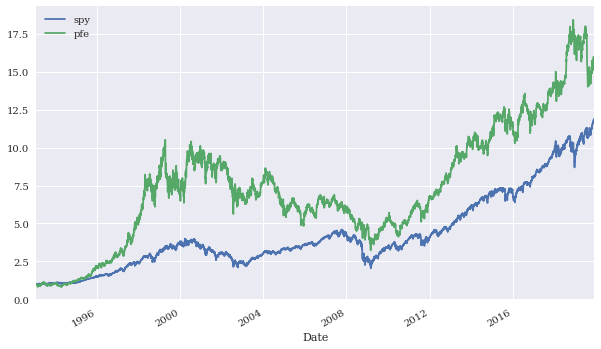

In [379]:
data.plot(figsize=(10,6))

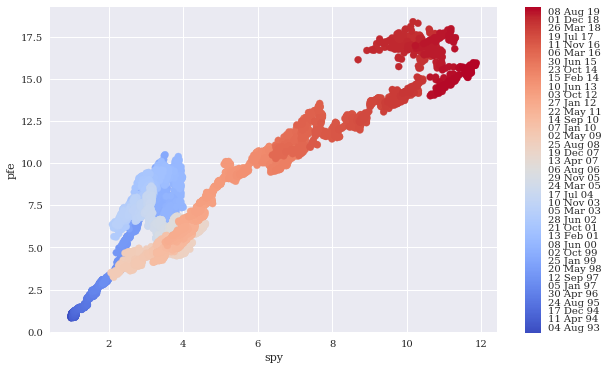

In [380]:
mpl_dates = mpl.dates.date2num(data.index.to_pydatetime())
plt.figure(figsize=(10, 6))
plt.scatter(data['spy'], data['pfe'], c=mpl_dates, marker='o', cmap='coolwarm')
plt.xlabel('spy')
plt.ylabel('pfe')
plt.colorbar(ticks=mpl.dates.DayLocator(interval=250),format=mpl.dates.DateFormatter('%d %b %y'));

In [371]:
import pymc3 as pm
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=20)
    beta = pm.Normal('beta', mu=0, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    y_est = alpha + beta * data['spy'].values
    likelihood = pm.Normal('pfe', mu=y_est, sd=sigma, observed=data['pfe'].values)
    start = pm.find_MAP()
    step = pm.NUTS()
    trace = pm.sample(500, tune=1000, start=start,progressbar=True)


W1209 14:51:36.447117 19616 compilelock.py:241] Overriding existing lock by dead process '4836' (I am process '16792')
c:\users\drimbg\.conda\envs\my_env\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -12,607, ||grad|| = 68.481: 100%|██████████████████| 26/26 [00:00<00:00, 720.28it/s]
Sampling 4 chains: 100%|███████████████████████████| 6000/6000 [00:10<00:00, 574.98draws/s]
c:\users\drimbg\.conda\envs\my_env\lib\site-packages\scipy\signal\signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_re

In [372]:
pm.summary(trace)

c:\users\drimbg\.conda\envs\my_env\lib\site-packages\pymc3\stats.py:982: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,1.360441,0.039199,0.001063,1.285089,1.434987,1141.648540,0.999455
beta,1.409841,0.007910,0.000219,1.394624,1.425232,1096.453989,0.999895
sigma,1.557177,0.013273,0.000339,1.531451,1.582283,1511.897282,1.003742


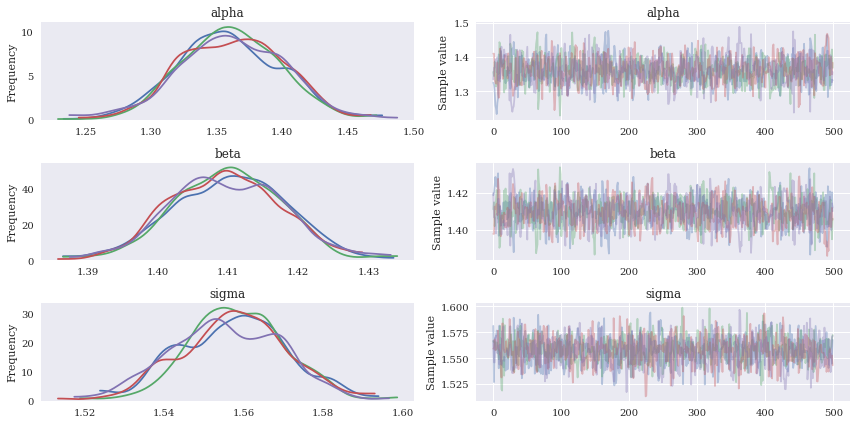

In [373]:
fig = pm.traceplot(trace)

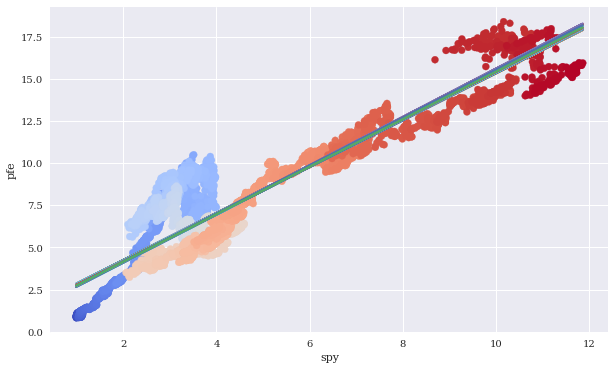

In [374]:
plt.figure(figsize=(10, 6))
plt.scatter(data['spy'], data['pfe'], c=mpl_dates,
         marker='o', cmap='coolwarm')
plt.xlabel('spy')
plt.ylabel('pfe')
for i in range(len(trace)):
    plt.plot(data['spy'],
          trace['alpha'][i] + trace['beta'][i] * data['spy'])